In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import cv2
from PIL import Image
import random

In [2]:
#set this to True if you want to train the model.
#Train = True
Train = False

In [3]:
if Train == True :
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [4]:
SEED = 6
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, image_paths, target_paths,train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.files = os.listdir(self.image_paths)
        self.lables = os.listdir(self.target_paths)
    
    def transform(self, image, mask):        
        # Random crop
        if random.random() > 0.5:
            affine_params=transforms.RandomAffine(180).get_params((-90, 90), (0.1,0.1), (0.8, 1.2), None, image.size)
            image = TF.affine(image, *affine_params)
            mask = TF.affine(mask, *affine_params)    

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Normalize the image
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        image = norm(image)
        
        return image, mask

    def __getitem__(self, idx):
        img_name = self.files[idx]
        label_name = self.lables[idx]
        
        image = Image.open(os.path.join(self.image_paths,img_name))
        mask = Image.open(os.path.join(self.target_paths,label_name))        
       
        x, y= self.transform(image,mask)
        return x, y
     
    def __len__(self):
        
        return len(self.files)

In [6]:
#set the path of images and their labels
image_path = 'Trainset3/Image'
label_paht = 'Trainset3/Label'
dataset = MyDataset(image_path,label_paht)

In [7]:
#split dataset to train and validation set
train_length=int(0.90* len(dataset))
test_length=len(dataset)-train_length
train_dataset,val_dataset = torch.utils.data.random_split(dataset, (train_length,test_length))

In [8]:
#create data loader for train and validation set
trainloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True)
valloader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=True, pin_memory=True)

In [9]:
#download the model
unet = smp.Unet("resnet18", encoder_weights="imagenet", classes=1, activation=None)

In [10]:
unet = unet.to(device)

In [11]:
#add dropout to encoder
unet.encoder.layer3[1].add_module("dropout", torch.nn.Dropout(p=0.35))
unet.encoder.layer4[1].add_module("dropout", torch.nn.Dropout(p=0.35))

In [12]:
#add dropout to decoder
unet.decoder.blocks[2].conv2.add_module("dropout", torch.nn.Dropout(p=0.25))
unet.decoder.blocks[3].conv2.add_module("dropout", torch.nn.Dropout(p=0.25))

In [13]:
#freeze the model partially, hopefully improves some validation accuracy
for i,child1 in enumerate(unet.children()): 
    if i == 0:
        for j, child2 in enumerate(child1.children()):
            if j<=3:
                for param in child2.parameters():
                    param.requires_grad = False

In [14]:
#use dice score as an accuracy metric to measure similarity between two images
def dice_score(pred, target,smooth=1):
    
  
    pred = torch.sigmoid(pred)
    N = target.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = target.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    #unionset = pred_flat.sum(1) + gt_flat.sum(1)
    unionset = (pred_flat ** 2).sum(1) + (gt_flat ** 2).sum(1)
    loss = ((2. * (intersection)) + smooth) / (unionset + smooth)
    return loss.sum() / N
    
''' initialize an empty list when Scores is called, append the list with dice scores
for every batch, at the end of epoch calculates mean of the dice scores'''
class Scores:
    def __init__(self, phase, epoch):
        self.base_dice_scores = []

    def update(self, targets, outputs):
        probs = outputs
        dice= dice_score(probs, targets)
        self.base_dice_scores.append(dice.item())

    def get_metrics(self): 
        dice = sum(self.base_dice_scores)/len(self.base_dice_scores)
        return dice

'''return dice score for epoch when called'''
def epoch_log(phase, epoch_loss, measure):
    '''logging the metrics at the end of an epoch'''
    dices= measure.get_metrics()                          
    print("%s: Loss: %0.4f |dice: %0.4f" % (phase, epoch_loss, dices))
    return dices


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'
 
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        return 1 - dice_score(pred, target)


In [15]:
'''
#train
if Train == True:
    
    optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,70], gamma=0.1)
    #criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(12.))
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.))
    dice_train_loss = DiceLoss() 
    dice_val_loss = DiceLoss() 
    criterion_val = torch.nn.BCEWithLogitsLoss()
    n_epochs = 85
    epoch_train_loss = []
    epoch_train_dice = []
    epoch_val_loss = []
    epoch_val_dice = []
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        #torch.cuda.empty_cache()
        train_score=Scores('Train',epoch)
        val_score=Scores('Validation',epoch)
        loss_train_avg = 0
        loss_val_avg = 0
        unet.train()
        print('epoch' + str(epoch))
        for i, data in enumerate(trainloader,0):
            optimizer.zero_grad()
            img,mask = data
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = unet(img)
            train_score.update(mask,output)
            train_loss = criterion(output,mask)
            d_train_loss = dice_train_loss(output,mask)
            total_train_loss = train_loss+(d_train_loss)
            total_train_loss.backward()
            optimizer.step()
            loss_train_avg = loss_train_avg+total_train_loss.item()
            
        
        with torch.no_grad():
            unet.eval()
            for i, data in enumerate(valloader,0):
                img,mask = data
                img = img.to(device, dtype=torch.float)
                mask = mask.to(device, dtype=torch.float)
                output = unet(img)
                val_score.update(mask,output)
                val_loss = criterion_val(output,mask)
                d_val_loss = dice_val_loss(output,mask)
                total_val_loss = val_loss + (d_val_loss) 
                #print(total_val_loss)
                loss_val_avg = loss_val_avg+total_val_loss.item()
            
        
            
        loss_ep_train = loss_train_avg/len(trainloader)
        dice_train = epoch_log('Train',loss_ep_train, train_score)
        epoch_train_loss.append(loss_ep_train)
        epoch_train_dice.append(dice_train)
        
        loss_ep_val = loss_val_avg/len(valloader)
        dice_val = epoch_log('Validation',loss_ep_val, val_score)
        epoch_val_loss.append(loss_ep_val)
        epoch_val_dice.append(dice_val)
        
        scheduler.step()
        
'''


epoch0
Train: Loss: 0.9572 |dice: 0.3944
Validation: Loss: 0.6802 |dice: 0.4198
epoch1
Train: Loss: 0.8680 |dice: 0.4364
Validation: Loss: 0.7039 |dice: 0.4242
epoch2
Train: Loss: 0.8427 |dice: 0.4501
Validation: Loss: 0.6380 |dice: 0.4597
epoch3
Train: Loss: 0.8284 |dice: 0.4589
Validation: Loss: 0.7056 |dice: 0.4276
epoch4
Train: Loss: 0.8452 |dice: 0.4578
Validation: Loss: 0.6149 |dice: 0.4807
epoch5
Train: Loss: 0.8306 |dice: 0.4672
Validation: Loss: 0.6520 |dice: 0.4620
epoch6
Train: Loss: 0.8147 |dice: 0.4786
Validation: Loss: 0.6457 |dice: 0.4588
epoch7
Train: Loss: 0.8267 |dice: 0.4764
Validation: Loss: 0.6282 |dice: 0.4824
epoch8
Train: Loss: 0.8385 |dice: 0.4739
Validation: Loss: 0.6012 |dice: 0.4959
epoch9
Train: Loss: 0.8177 |dice: 0.4856
Validation: Loss: 0.6458 |dice: 0.4644
epoch10
Train: Loss: 0.8090 |dice: 0.4903
Validation: Loss: 0.5726 |dice: 0.5178
epoch11
Train: Loss: 0.7910 |dice: 0.5011
Validation: Loss: 0.5979 |dice: 0.5000
epoch12
Train: Loss: 0.7875 |dice: 0.5

In [15]:
#train
if Train == True:
    
    optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,70], gamma=0.1)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.))
    criterion_val = torch.nn.BCEWithLogitsLoss()
    n_epochs = 85
    epoch_train_loss = []
    epoch_train_dice = []
    epoch_val_loss = []
    epoch_val_dice = []
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        train_score=Scores('Train',epoch)
        val_score=Scores('Validation',epoch)
        loss_train_avg = 0
        loss_val_avg = 0
        unet.train()
        print('epoch' + str(epoch))
        for i, data in enumerate(trainloader,0):
            optimizer.zero_grad()
            img,mask = data
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = unet(img)
            train_score.update(mask,output)
            train_loss = criterion(output,mask)
            
            train_loss.backward()
            optimizer.step()
            loss_train_avg = loss_train_avg+train_loss.item()
        
        with torch.no_grad():
            unet.eval()
            for i, data in enumerate(valloader,0):
                optimizer.zero_grad()
                img,mask = data
                img = img.to(device, dtype=torch.float)
                mask = mask.to(device, dtype=torch.float)
                output = unet(img)
                val_score.update(mask,output)
                val_loss = criterion_val(output,mask)
                loss_val_avg = loss_val_avg+val_loss.item()
            
        
            
        loss_ep_train = loss_train_avg/len(trainloader)
        dice_train = epoch_log('Train',loss_ep_train, train_score)
        epoch_train_loss.append(loss_ep_train)
        epoch_train_dice.append(dice_train)
        
        loss_ep_val = loss_val_avg/len(valloader)
        dice_val = epoch_log('Validation',loss_ep_val, val_score)
        epoch_val_loss.append(loss_ep_val)
        epoch_val_dice.append(dice_val)
        
        scheduler.step()


In [18]:
if Train == True:
    np.save('train_epoch_loss_backbone18_1', epoch_train_loss)
    np.save('train_epoch_dice_backbone18_1', epoch_train_dice)
    np.save('val_epoch_loss_backbone18_1', epoch_val_loss)
    np.save('val_epoch_dice_backbone18_1', epoch_val_dice)

In [16]:
if Train == True:
    state = {
                "state_dict": unet.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
    torch.save(state, 'unet_backbone18_1_final.pth')
else:
    unet = unet
    model = torch.load('unet_backbone18_1_final.pth', map_location=torch.device('cpu'))
    unet.load_state_dict(model['state_dict'])
    unet.to(device)
    unet.eval()

In [17]:
def dice_test(pred, target,smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred*target).sum()
    #union = pred.sum()+target.sum()
    union = (pred ** 2).sum() + (target ** 2).sum()
    return (((2. * intersection)+smooth)/(union+smooth)).item()
    

In [23]:
def dice_test2(pred, target,smooth=1):
    target = np.array(target)
    target = TF.to_tensor(target).unsqueeze(dim=0)
    pred = torch.sigmoid(pred)
    #print(torch.max(pred))
    if target.sum().item() == 0:
        pred = (pred>0.5).float()
    N = target.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = target.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    #unionset = pred_flat.sum(1) + gt_flat.sum(1)
    unionset = (pred_flat ** 2).sum(1) + (gt_flat ** 2).sum(1)
    #print(pred_flat)
    #print(intersection)
    #print(unionset)
    loss = ((2. * intersection) + smooth) / (unionset + smooth)
    return loss.sum().item() / N

In [24]:
TEST_PATH = 'Trainset2/Test/60.PNG' #path to the image that we want to test
TEST_Label = 'Trainset2/Testlabel/60.PNG'
img_input = Image.open(TEST_PATH)
img_input = np.array(img_input)
img_input = TF.to_tensor(img_input).unsqueeze(dim=0)
img_input = img_input.to(device, dtype=torch.float)

In [25]:
output = unet(img_input)
target = Image.open(TEST_Label)

In [26]:
dice_test2(output.cpu(),target)

0.7699552774429321

In [27]:
output = torch.sigmoid(output)
predicted = output[0].squeeze(dim=0)

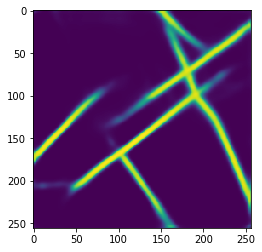

In [28]:
plt.imshow(predicted.cpu().detach().numpy())

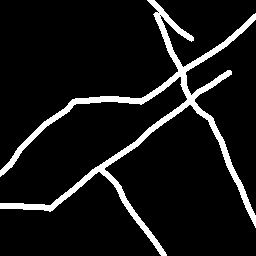

In [29]:
target

In [ ]:
def predict(model,test_img,target_img):
    device = torch.device('cpu')
    with torch.no_grad():
        model.eval()
    img_input = np.array(test_img)
    img_input = TF.to_tensor(img_input).unsqueeze(dim=0)
    img_input = img_input.to(device, dtype=torch.float)
    output = unet(img_input)
    acc = dice_test2(output,target_img)
    output = torch.sigmoid(output)
    predicted = output[0].squeeze(dim=0)
    predicted_array = predicted.detach().cpu().numpy()
    
    #G = np.zeros((256,256,3))
    #G[predicted_array>-6] = [1,1,1]
    #G[predicted_array<-6] = [0,0,0]
    return predicted_array, acc